In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
from scipy.stats import multivariate_normal as mvn
from sklearn.metrics import pairwise_distances
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from sklearn.metrics import r2_score
import seaborn as sns
from scipy.spatial import ConvexHull
from tqdm import tqdm

import sys

sys.path.append("../../models/")
sys.path.append("../../util/")
from tissue import Tissue
from eig_gp import compute_eig_gp

import matplotlib

font = {"size": 30}
matplotlib.rc("font", **font)
matplotlib.rcParams["text.usetex"] = True

sys.path.append("../../util/")
from util import get_points_near_line

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
n_iters = 10
n_repeats = 3
length_scale = 5
noise_variance = 1e0

# When we take a slice, all points within this
# distance to the line/plane are "observed"
slice_radius = 0.5

grid_size = 15
xlimits = [-10, 10]
ylimits = [-10, 10]


r2_scores = np.zeros((n_repeats, n_iters))
r2_scores_random = np.zeros((n_repeats, n_iters))
r2_scores_naive = np.zeros((n_repeats, n_iters))


for rep_ii in tqdm(range(n_repeats)):
    
    x1s = np.linspace(*xlimits, num=grid_size)
    x2s = np.linspace(*ylimits, num=grid_size)
    X1, X2 = np.meshgrid(x1s, x2s)
    X = np.vstack([X1.ravel(), X2.ravel()]).T
    X += np.random.uniform(low=-0.5, high=0.5, size=X.shape)

    # Warp coordinates with GP
    X1 = mvn.rvs(mean=X[:, 0], cov=RBF(length_scale=4)(X) + 1e-5 * np.eye(len(X)))
    X2 = mvn.rvs(mean=X[:, 1], cov=RBF(length_scale=4)(X) + 1e-5 * np.eye(len(X)))
    X = np.vstack([X1, X2]).T

    # Generate response
    Y_full = mvn.rvs(mean=np.zeros(X.shape[0]), cov=RBF(length_scale=length_scale)(X) + noise_variance * np.eye(len(X)))

    ###### BOED ######
    # Discretize design space
    n_slope_discretizations = 30
    n_intercept_discretizations = 10
#     slope_angles = np.linspace(0, np.pi, n_slope_discretizations)
#     slopes = np.tan(slope_angles)
    slopes = np.linspace(-10, 10, n_slope_discretizations)
    intercepts = np.linspace(
        np.min(X[:, 1]) - 5, np.max(X[:, 1]) + 5, n_intercept_discretizations
    )
    # intercepts = np.random.choice(np.unique(X[:, 1]), size=n_intercept_discretizations, replace=False)
    designs1, designs2 = np.meshgrid(intercepts, slopes)
    candidate_designs = np.vstack([designs1.ravel(), designs2.ravel()]).T

    n_candidate_designs = len(candidate_designs)


    designs = []
    observed_idx = []
    X_fragment_idx = [np.arange(len(X))]
    for iternum in range(n_iters):

        assert len(designs) == iternum
        assert len(X_fragment_idx) == iternum + 1

        if len(observed_idx) > 0:
            kernel = RBF(length_scale=5) + WhiteKernel()
            gpr = GPR(kernel=kernel) #, optimizer=None)
            gpr.fit(
                X[np.unique(observed_idx)],
                Y_full[np.unique(observed_idx)],
            )
            noise_variance = np.exp(gpr.kernel_.k2.theta[0])

        best_eig = -np.inf
        best_design_idx, best_fragment_idx, best_observed_idx = None, None, None

        for ff in range(len(X_fragment_idx)):

            # Get data for this fragment
            curr_X = X[X_fragment_idx[ff]]

            for dd in range(n_candidate_designs):

                # Get points that would be observed by this slice
                curr_design = candidate_designs[dd]

                above_fragment_idx = np.where(
                    curr_X[:, 1] >= curr_design[0] + curr_X[:, 0] * curr_design[1]
                )[0]

                curr_observed_idx = get_points_near_line(
                    X=curr_X,
                    slope=curr_design[1],
                    intercept=curr_design[0],
                    slice_radius=slice_radius,
                )
                assert len(np.intersect1d(observed_idx, X_fragment_idx[ff][curr_observed_idx])) == 0

                L = len(curr_observed_idx)
                if L == 0:
                    continue

                if iternum == 0:
                    kernel = RBF(length_scale=5) + WhiteKernel()
                    cov = kernel(curr_X[curr_observed_idx])
                    noise_variance = np.exp(kernel.k2.theta[0])
                else:
                    # Make predictions of expression
                    _, cov = gpr.predict(curr_X[curr_observed_idx], return_cov=True)

                curr_eig = 0.5 * np.linalg.slogdet(1 / noise_variance * cov + np.eye(L))[1]

                if curr_eig > best_eig:
                    best_design_idx = dd
                    best_fragment_idx = ff
                    best_observed_idx = X_fragment_idx[ff][curr_observed_idx]
                    best_eig = curr_eig

        curr_best_design = candidate_designs[best_design_idx]

        best_fragment_X = X[X_fragment_idx[best_fragment_idx]]

        above_fragment_idx = np.where(
            best_fragment_X[:, 1]
            >= curr_best_design[0] + best_fragment_X[:, 0] * curr_best_design[1]
        )[0]
        below_fragment_idx = np.where(
            best_fragment_X[:, 1]
            <= curr_best_design[0] + best_fragment_X[:, 0] * curr_best_design[1]
        )[0]

        above_idx = X_fragment_idx[best_fragment_idx][above_fragment_idx]
        below_idx = X_fragment_idx[best_fragment_idx][below_fragment_idx]
        above_idx = np.setdiff1d(above_idx, best_observed_idx)
        below_idx = np.setdiff1d(below_idx, best_observed_idx)

        X_fragment_idx.pop(best_fragment_idx)
        X_fragment_idx.append(above_idx)
        X_fragment_idx.append(below_idx)

        designs.append(curr_best_design)
        observed_idx.extend(best_observed_idx)

        ## Run prediction
        train_idx = np.array(observed_idx)
        test_idx = np.setdiff1d(np.arange(len(X)), train_idx)
        X_train, Y_train = X[train_idx], Y_full[train_idx]
        X_test, Y_test = X[test_idx], Y_full[test_idx]

        gpr = GPR(kernel=kernel) #, optimizer=None)
        gpr.fit(X_train, Y_train)
        preds = gpr.predict(X_test)
        curr_r2 = r2_score(Y_test, preds)
        r2_scores[rep_ii, iternum] = curr_r2



    ###### Random design ######
    designs_random = []
    observed_idx_random = []
    X_fragment_idx_random = [np.arange(len(X))]

    for iternum in range(n_iters):

        assert len(designs_random) == iternum
        assert len(X_fragment_idx_random) == iternum + 1

        curr_observed_idx = []
        while len(curr_observed_idx) == 0:
            rand_fragment_idx = np.random.choice(np.arange(len(X_fragment_idx_random)))
            rand_design_idx = np.random.choice(np.arange(n_candidate_designs))

            curr_design = candidate_designs[rand_design_idx]
            curr_X = X[X_fragment_idx_random[rand_fragment_idx]]
            curr_observed_idx = get_points_near_line(
                X=curr_X,
                slope=curr_design[1],
                intercept=curr_design[0],
                slice_radius=slice_radius,
            )
            
            assert len(np.intersect1d(observed_idx_random, X_fragment_idx_random[rand_fragment_idx][curr_observed_idx])) == 0

        best_fragment_X = X[X_fragment_idx_random[rand_fragment_idx]]

        observed_idx_random.extend(
            X_fragment_idx_random[rand_fragment_idx][curr_observed_idx].tolist()
        )

        above_fragment_idx = np.where(
            best_fragment_X[:, 1]
            >= curr_design[0] + best_fragment_X[:, 0] * curr_design[1]
        )[0]
        below_fragment_idx = np.where(
            best_fragment_X[:, 1]
            <= curr_design[0] + best_fragment_X[:, 0] * curr_design[1]
        )[0]

        above_idx = X_fragment_idx_random[rand_fragment_idx][above_fragment_idx]
        below_idx = X_fragment_idx_random[rand_fragment_idx][below_fragment_idx]
        above_idx = np.setdiff1d(above_idx, X_fragment_idx_random[rand_fragment_idx][curr_observed_idx])
        below_idx = np.setdiff1d(below_idx, X_fragment_idx_random[rand_fragment_idx][curr_observed_idx])
        X_fragment_idx_random.pop(rand_fragment_idx)
        X_fragment_idx_random.append(above_idx)
        X_fragment_idx_random.append(below_idx)

        designs_random.append(curr_design)

        train_idx = np.array(observed_idx_random)
        test_idx = np.setdiff1d(np.arange(len(X)), train_idx)
        X_train, Y_train = X[train_idx], Y_full[train_idx]
        X_test, Y_test = X[test_idx], Y_full[test_idx]

        kernel = RBF(length_scale=5) + WhiteKernel()
        gpr = GPR(kernel=kernel)
        gpr.fit(X_train, Y_train)
        preds = gpr.predict(X_test)
        curr_r2 = r2_score(Y_test, preds)
        r2_scores_random[rep_ii, iternum] = curr_r2



    ## Naive design

    

    slopes = np.zeros(n_iters)
#     intercepts = np.linspace(
#         np.min(X[:, 1]), np.max(X[:, 1]), n_iters + 2
#     )[1:-1]
    intercepts = np.linspace(
        np.min(X[:, 1]) + 1, np.max(X[:, 1]) - 1, n_iters
    )
#     designs1, designs2 = np.meshgrid(intercepts, slopes)
#     designs_naive = np.vstack([designs1.ravel(), designs2.ravel()]).T
    designs_naive = np.vstack([intercepts, slopes]).T


    design_indices = np.arange(n_iters)

    observed_idx_naive = []

    curr_shuffled_indices = np.random.choice(design_indices, size=len(design_indices), replace=False)

    for iternum, design_idx in enumerate(curr_shuffled_indices):

        curr_design = designs_naive[design_idx]

        curr_observed_idx = get_points_near_line(
            X=X,
            slope=curr_design[1],
            intercept=curr_design[0],
            slice_radius=slice_radius,
        )
        observed_idx_naive.extend(
            curr_observed_idx.tolist()
        )

        train_idx = np.array(observed_idx_naive)
        test_idx = np.setdiff1d(np.arange(len(X)), train_idx)
        X_train, Y_train = X[train_idx], Y_full[train_idx]
        X_test, Y_test = X[test_idx], Y_full[test_idx]

        kernel = RBF() + WhiteKernel()
        gpr = GPR(kernel=kernel) #, optimizer=None)
        gpr.fit(X_train, Y_train)
        preds = gpr.predict(X_test)
        curr_r2 = r2_score(Y_test, preds)
        r2_scores_naive[rep_ii, iternum] = curr_r2




 33%|███▎      | 1/3 [00:02<00:04,  2.04s/it]/Users/andrewjones/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/andrewjones/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/andrewjones/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better valu

In [3]:
frac_drop = 0.5

mse_full_atlas = np.zeros(n_repeats)
for ii in range(n_repeats):
    
    # Randomly drop points
    test_idx = np.random.choice(np.arange(len(X)), size=int(frac_drop * len(X)), replace=False)
    train_idx = np.setdiff1d(np.arange(len(X)), test_idx)
    coords_train, outcome_train = X[train_idx], Y_full[train_idx]
    coords_test, outcome_test = X[test_idx], Y_full[test_idx]
    
    # Fit GP
    gpr = GPR(kernel=RBF() + WhiteKernel()) #, optimizer=None)
    gpr.fit(coords_train, outcome_train)
    
    # Make predictions for dropped points
    preds = gpr.predict(coords_test)
    
    # Compute R^2
    mse_full_atlas[ii] = r2_score(outcome_test, preds)
    print(mse_full_atlas[ii])
print(mse_full_atlas)

0.12798531201100816
0.19042724146998813
0.20833595042033315
[0.12798531 0.19042724 0.20833595]


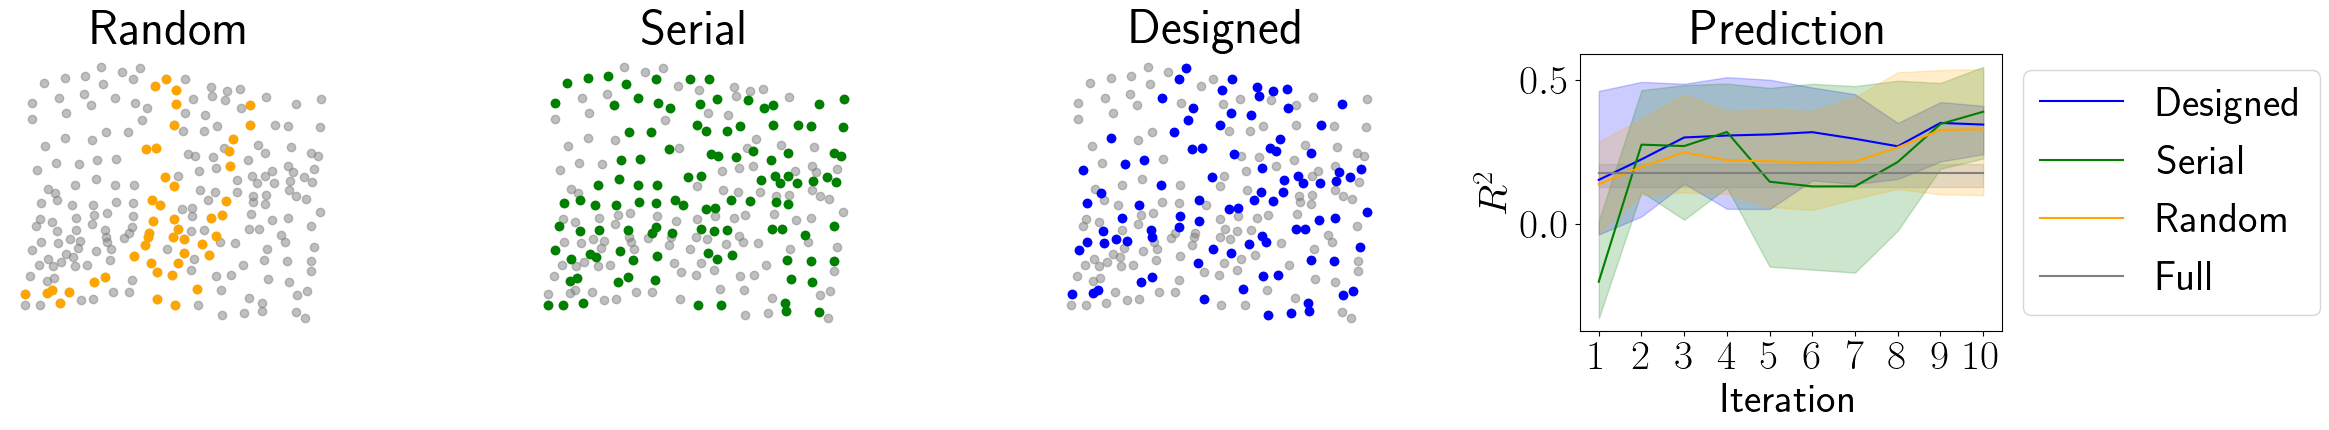

In [4]:

# plt.figure(figsize=(21, 6))
fig, ax = plt.subplots(
    1, 4, figsize=(24, 5), gridspec_kw={"width_ratios": [1, 1, 1, 1.3]}
)

# plt.subplot(141)
plt.sca(ax[0])
plt.title("Random")
plt.scatter(X[:, 0], X[:, 1], c="gray", alpha=0.5)
plt.scatter(X[np.array(observed_idx_random), 0], X[np.array(observed_idx_random), 1], color="orange")
plt.axis("off")
plt.legend([],[], frameon=False)

# plt.subplot(142)
plt.sca(ax[1])
plt.title("Serial")
plt.scatter(X[:, 0], X[:, 1], c="gray", alpha=0.5)
plt.scatter(X[np.array(observed_idx_naive), 0], X[np.array(observed_idx_naive), 1], color="green")
plt.axis("off")
plt.legend([],[], frameon=False)

# plt.subplot(143)
plt.sca(ax[2])
plt.title("Designed")
plt.scatter(X[:, 0], X[:, 1], c="gray", alpha=0.5)
# plt.scatter(X[np.array(observed_idx_random), 0], X[np.array(observed_idx_random), 1], label="Random", color="orange")
# plt.scatter(X[np.array(observed_idx_naive), 0], X[np.array(observed_idx_naive), 1], label="Naive", color="green")
plt.scatter(X[np.array(observed_idx), 0], X[np.array(observed_idx), 1], label="Designed", color="blue")
plt.axis("off")
plt.legend([],[], frameon=False)
# plt.tight_layout()

# plt.subplot(144)
plt.sca(ax[3])
plt.title("Prediction")

# results_df = pd.DataFrame({"iter": np.arange(1, n_iters + 1), "r2": r2_scores})
# results_df_naive = pd.DataFrame({"iter": np.arange(1, n_iters + 1), "r2": r2_scores_naive})
results_df = pd.melt(pd.DataFrame(r2_scores))
results_df["variable"] += 1
results_df_naive = pd.melt(pd.DataFrame(r2_scores_naive))
results_df_naive["variable"] += 1
results_df_random = pd.melt(pd.DataFrame(r2_scores_random))
results_df_random["variable"] += 1

results_df_full_atlas = pd.DataFrame({"iter": results_df_random.variable.values, "r2": np.tile(mse_full_atlas, n_iters)})


# sns.lineplot(data=results_df, x="iter", y="r2", label="Designed", color="blue")
# sns.lineplot(data=results_df_naive, x="iter", y="r2", label="Serial", color="green")
sns.lineplot(
    data=results_df,
    x="variable",
    y="value",
    label="Designed",
    color="blue",
)
sns.lineplot(
    data=results_df_naive,
    x="variable",
    y="value",
    label="Serial",
    color="green",
)
sns.lineplot(
    data=results_df_random,
    x="variable",
    y="value",
    label="Random",
    color="orange",
)
sns.lineplot(
    data=results_df_full_atlas,
    x="iter",
    y="r2",
    label="Full",
    color="Gray",
)
plt.xticks(np.arange(1, n_iters + 1))
plt.xlabel("Iteration")
plt.ylabel(r"$R^2$")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()


plt.savefig("./out/simulated_prediction_experiment.png")
plt.show()


In [5]:
slopes


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])